In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from colors import *

In [34]:
noisy = np.load('sissle_noisy.npy')
sg = np.load('sissle_sg.npy')
dip = np.load('sissle_dip.npy')
sg_nofilter = np.load('sissle_sg_nofilter.npy')
dip_nofilter = np.load('sissle_dip_nofilter.npy')
idf = np.load('sissle_idf.npy').T

noisy = [noisy, noisy]
sg = [sg, sg_nofilter]
dip = [dip, dip_nofilter]
idf = [idf, idf]

In [35]:
def xcorr(x, y):
    
    # FFT of x and conjugation
    X_bar = np.fft.rfft(x).conj()
    Y = np.fft.rfft(y)
    
    # Compute norm of data
    norm_x_sq = np.sum(x**2)
    norm_y_sq = np.sum(y**2)
    norm = np.sqrt(norm_x_sq * norm_y_sq)
    
    # Correlation coefficients
    R = np.fft.irfft(X_bar * Y) / norm
    
    # Return correlation coefficient
    return np.max(R)

def compute_xcorr_window(x):
    Nch = x.shape[0]
    Cxy = np.zeros((Nch, Nch)) * np.nan
    
    for i in range(Nch):
        for j in range(i):
            Cxy[i, j] = xcorr(x[i], x[j])
    
    return np.nanmean(Cxy)

def compute_moving_coherence(data, bin_size):
    
    N_ch = data.shape[0]
    
    cc = np.zeros(N_ch)
    
    for i in range(N_ch):
        start = max(0, i - bin_size // 2)
        stop = min(i + bin_size // 2, N_ch)
        ch_slice = slice(start, stop)
        cc[i] = compute_xcorr_window(data[ch_slice])
        
    return cc

In [36]:
cc_noisy = compute_moving_coherence(noisy[0], 11)
cc_sg = [compute_moving_coherence(sg[i], 11) for i in range(2)]
cc_dip = [compute_moving_coherence(dip[i], 11) for i in range(2)]
cc_idf = compute_moving_coherence(idf[0], 11)

cc_gain_sg = [cc / cc_noisy for cc in cc_sg]
cc_gain_dip = [cc / cc_noisy for cc in cc_dip]
cc_gain_idf = cc_idf / cc_noisy

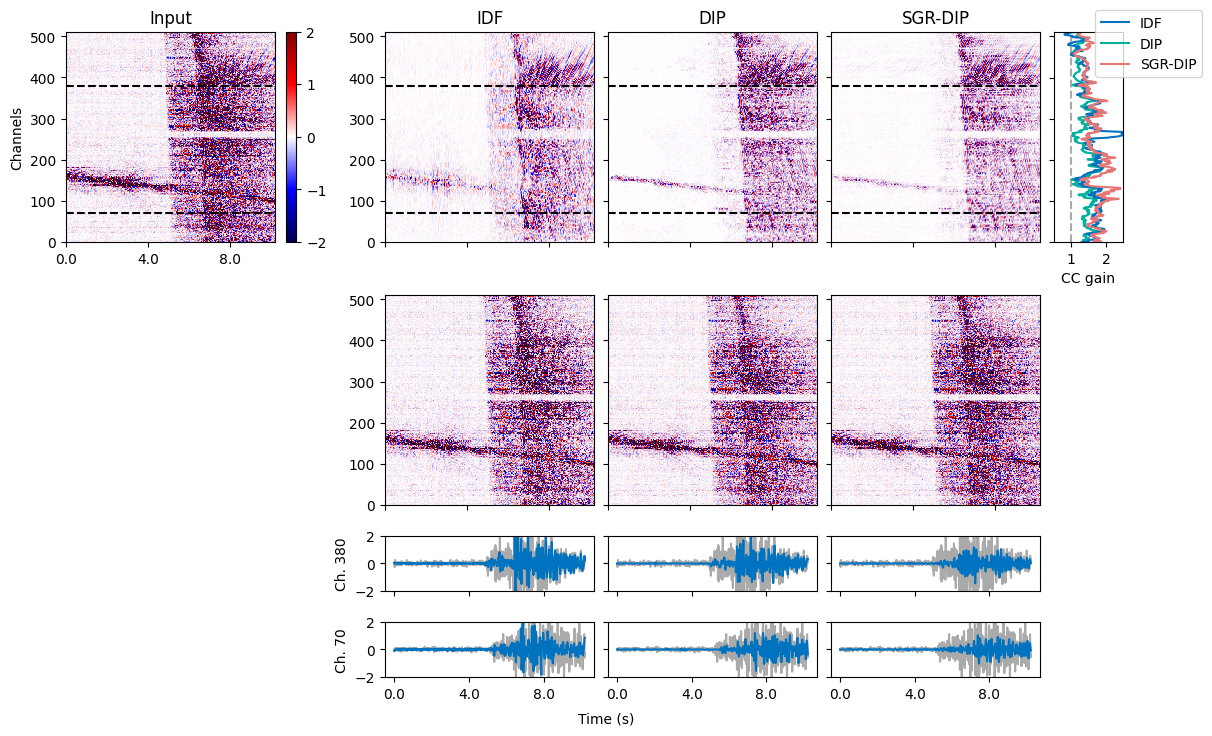

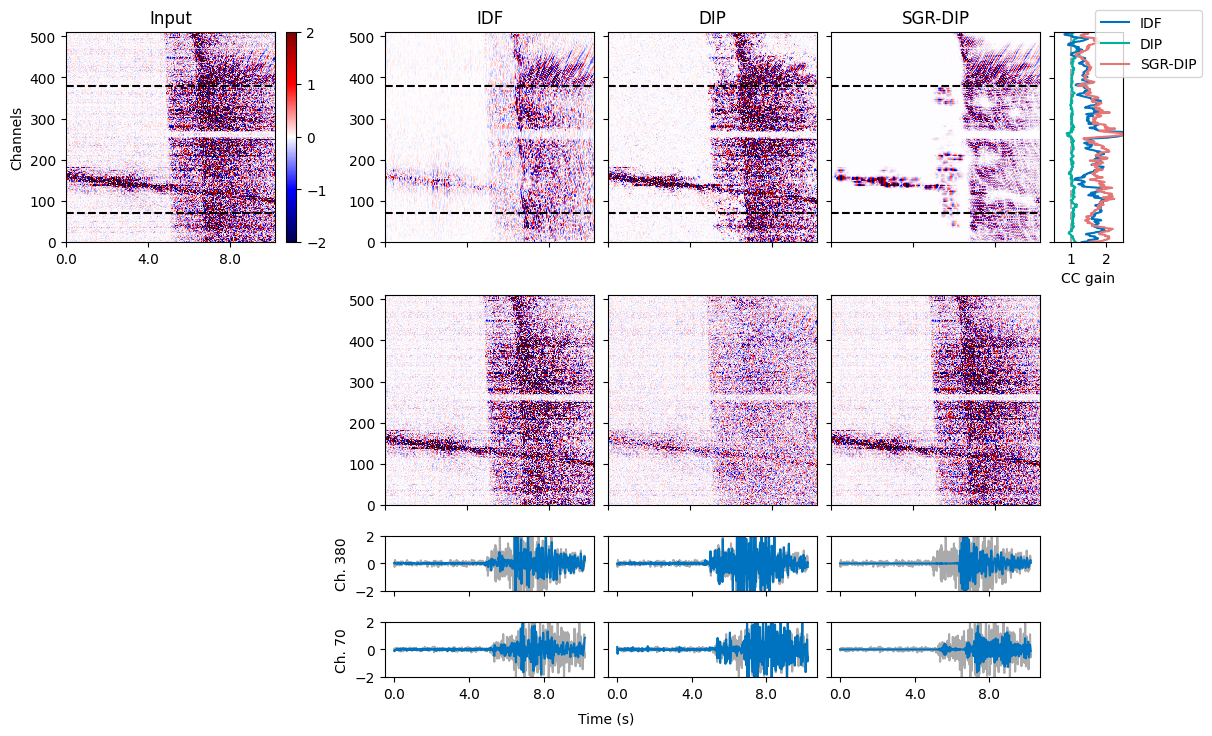

In [37]:
for i in range(2):
    fig, axs = plt.subplot_mosaic([
        ['a','a','a','b','b','b','c','c','c','d','d','d','e'],
        ['a','a','a','b','b','b','c','c','c','d','d','d','e'],
        ['a','a','a','b','b','b','c','c','c','d','d','d','e'],
        ['a1','a1','a1','b1','b1','b1','c1','c1','c1','d1','d1','d1','e1'],
        ['a1','a1','a1','b1','b1','b1','c1','c1','c1','d1','d1','d1','e1'],
        ['a1','a1','a1','b1','b1','b1','c1','c1','c1','d1','d1','d1','e1'],
        ['a2','a2','a2','b2','b2','b2','c2','c2','c2','d2','d2','d2','e1'],
        ['a3','a3','a3','b3','b3','b3','c3','c3','c3','d3','d3','d3','e1'],
    ], layout='constrained', figsize=(12, 7))

    v = 2
    im = axs['a'].imshow(noisy[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['b'].imshow(idf[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['c'].imshow(dip[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['d'].imshow(sg[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['b1'].imshow(noisy[i] - idf[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['c1'].imshow(noisy[i] - dip[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
    axs['d1'].imshow(noisy[i] - sg[i], origin='lower', interpolation='none', cmap='seismic', aspect='auto', vmin=-v, vmax=v)

    axs['e'].axvline(1, ls="--", c="#aaa")
    axs['e'].plot(cc_gain_dip[i], np.arange(512), c=GREEN, label='DIP')
    axs['e'].plot(cc_gain_idf, np.arange(512), c=BLUE, label='IDF')
    axs['e'].plot(cc_gain_sg[i], np.arange(512), c=LIGHT_RED, label='SGR-DIP')
    axs['e'].set_xlim((0.5, 2.5))
    axs['e'].set_ylim((0, 512))
    axs['e'].set_xlabel('CC gain')

    handles, labels = axs['e'].get_legend_handles_labels()
    order = [1,0,2]
    axs['e'].legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, 0.75))

    axs['a1'].set_visible(False)
    axs['a2'].set_visible(False)
    axs['a3'].set_visible(False)
    axs['e1'].set_visible(False)

    ch1 = 380
    ch2 = 70

    for s in ['a', 'b', 'c', 'd']:
        axs[s].axhline(ch1, ls="--", c='black')
        axs[s].axhline(ch2, ls="--", c='black')

    for j, ch in enumerate([ch1, ch2]):
        axs[f'b{j+2}'].plot(noisy[i][ch], c='#aaa')
        axs[f'b{j+2}'].plot(idf[i][ch], c=BLUE)
        axs[f'c{j+2}'].plot(noisy[i][ch], c='#aaa')
        axs[f'c{j+2}'].plot(dip[i][ch], c=BLUE)
        axs[f'd{j+2}'].plot(noisy[i][ch], c='#aaa')
        axs[f'd{j+2}'].plot(sg[i][ch], c=BLUE)

    axs['b2'].set_ylabel(f'Ch. {ch1}')
    axs['b3'].set_ylabel(f'Ch. {ch2}')

    for s in ['a','b','c','d','b1','c1','d1','b2','c2','d2','b3','c3','d3']:
        axs[s].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/50:.1f}'))

    for s in ['b','c','d','b1','c1','d1','b2', 'c2','d2']:
        axs[s].set_xticklabels([])

    for s in ['c','d','e','c1','d1','c2','d2','c3','d3']:
        axs[s].set_yticklabels([])

    for s in ['b2','b3','c2','c3','d2','d3']:
        axs[s].set_ylim((-2,2))

    axs['a'].set_ylabel('Channels')

    fig.text(0.5, -0.02, 'Time (s)', ha='center', va='center')

    axs['a'].set_title('Input')
    axs['b'].set_title('IDF')
    axs['c'].set_title('DIP')
    axs['d'].set_title('SGR-DIP')

    plt.colorbar(im, location='right')
    plt.savefig(f'fig_6.6_{i+1}.png', bbox_inches='tight', dpi=200)
    plt.show()